# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.stats import ttest_ind
from scipy.optimize import Bounds

from prettytable import PrettyTable

In [3]:
from multiprocessing import Pool
from functools import partial

In [4]:
import sys
sys.path.append("../smote_cd/")
import smote_cd

In [6]:
import sys
sys.path.append("../../coral_mapping/")
import segments_regressor
import coral_map_tests

In [7]:
import dirichlet_regression

In [15]:
# sur ordi MQ:
scipy.__version__

'1.9.1'

In [77]:
# sur mon ordi perso:
scipy.__version__

'1.4.1'

In [51]:
def cos_similarity(x1,x2):
    return(np.mean([np.dot(x1[i],x2[i])/(np.linalg.norm(x1[i])*np.linalg.norm(x2[i])) for i in range(len(x1))]))

# Loading Maupiti data

In [10]:
img_B02 = np.load('../../maupiti/Satellite Images/sentinel_B2_new.npy')
img_B03 = np.load('../../maupiti/Satellite Images/sentinel_B3_new.npy')
img_B04 = np.load('../../maupiti/Satellite Images/sentinel_B4_new.npy')
img_B08 = np.load('../../maupiti/Satellite Images/sentinel_B8_new.npy')

In [11]:
img_B02 = np.load('../../maupiti/Satellite Images/sentinel_B2_20220828.npy')
img_B03 = np.load('../../maupiti/Satellite Images/sentinel_B3_20220828.npy')
img_B04 = np.load('../../maupiti/Satellite Images/sentinel_B4_20220828.npy')
img_B08 = np.load('../../maupiti/Satellite Images/sentinel_B8_20220828.npy')

In [13]:
maupiti_zones = np.load('../../maupiti/Satellite Images/sentinel_rugo_new.npy')
#maupiti_zones = np.load('../maupiti/Satellite Images/sentinel_rugo_new_grouped_8.npy')

In [14]:
map_test=coral_map_tests.coral_map([img_B02,img_B03,img_B04,img_B08], map_img=maupiti_zones)

In [15]:
map_test.segmentation(method='fz',scale=0.9, min_size=40)
np.max(map_test.segments)

2322

In [16]:
boundaries = coral_map_tests.find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [17]:
X_maupiti = segments_regressor.create_features(map_test.segments, map_test.blue_band, map_test.green_band, map_test.red_band, map_test.nir_band)
Y_maupiti = coral_map_tests.create_labels_dataset(map_test.segments,map_test.map_img)

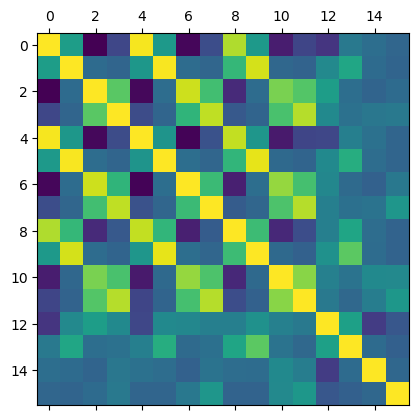

In [18]:
plt.matshow(X_maupiti.corr())
plt.show()

In [19]:
# Create correlation matrix
corr_matrix = X_maupiti.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]

# Drop features 
X_maupiti_less_features = X_maupiti.drop(to_drop, axis=1)

In [20]:
X_maupiti_less_features.corr()

,mean_blue,var_blue,mean_nir,skew_nir,kurt_nir
mean_blue,1.000000,0.338209,-0.259352,0.052624,0.004406
var_blue,0.338209,1.000000,0.213142,0.030445,-0.005806
mean_nir,-0.259352,0.213142,1.000000,-0.222240,-0.080753
skew_nir,0.052624,0.030445,-0.222240,1.000000,0.009483
kurt_nir,0.004406,-0.005806,-0.080753,0.009483,1.000000


In [21]:
#n_features = 5
n_classes = 15
n_samples = X_maupiti.shape[0]

In [22]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [26]:
Z_maupiti = np.ones((n_samples,n_features))

In [23]:
Z_maupiti = np.ones(n_samples).reshape(-1,1)
#Z_maupiti = np.ones((n_samples,2))
#Z_maupiti[:,1] = np.array(X_maupiti)[:,0]/np.max(np.array(X_maupiti)[:,0])

In [24]:
W_maupiti = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    W_maupiti[i,adjacent_segments[i]]=1

W_maupiti = W_maupiti/W_maupiti.sum(axis=1)[:,None]

In [25]:
X = StandardScaler().fit(X_maupiti_less_features).transform(X_maupiti_less_features)

In [71]:
n_features = 16
X = StandardScaler().fit(X_maupiti).transform(X_maupiti)

In [72]:
train_ind, test_ind = train_test_split(np.arange(len(X)),test_size=0.2)

X_train, X_test = X[train_ind], X[test_ind]
Y_train, Y_test = Y_star_maupiti[train_ind], Y_star_maupiti[test_ind]
Z_train, Z_test = Z_maupiti[train_ind], Z_maupiti[test_ind]
W_train, W_test = W_maupiti[train_ind][:,train_ind], W_maupiti[test_ind][:,test_ind]

# Regressor

## With 16 features

### With Loglikelihood

In [73]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train)

Optimization terminated successfully.
Wall time: 3.7 s


In [74]:
r2_score(Y_train,reg.mu)

-0.3364438444037062

In [75]:
mu_pred = reg.pred(X_test)

In [76]:
r2_score(Y_test,mu_pred)

-2.3821006387234576

### With crossentropy, no spatial

In [97]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, loss='crossentropy')

Optimization terminated successfully.
Wall time: 22 s


In [98]:
r2_score(Y_train,reg.mu)

0.4838197257623873

In [99]:
mu_pred = reg.pred(X_test)

In [100]:
r2_score(Y_test,mu_pred)

0.28540962755415233

### With crossentropy, spatial

In [160]:
%%time
reg = dirichlet_regression.dirichletRegressor(spatial=True)
reg.fit(X_train, Y_train, W=W_train, loss='crossentropy')

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Wall time: 17min 25s


In [161]:
r2_score(Y_train,reg.mu)

0.6105318463476359

In [162]:
mu_pred = reg.pred(X_test, W_test)

In [163]:
r2_score(Y_test,mu_pred)

-3.1075760837067934

In [164]:
cos_similarity(Y_test,mu_pred)

0.6327776844930929

## Generating new data

In [130]:
mu_pred = reg.pred(X)
phi = np.ones(n_samples)
alpha = np.copy(mu_pred)

In [148]:
Y_gen_1 = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y_gen_2 = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
#Y_gen = (Y_gen*(n_samples-1)+1/n_classes)/n_samples

In [149]:
cos_similarity(Y_gen_1, Y_gen_2)

0.7078637893750632

In [151]:
cos_similarity(Y_maupiti, Y_gen_1)

0.688130212638314

In [152]:
cos_similarity(Y_maupiti, Y_gen_2)

0.6947053171539339

In [146]:
np.sum(np.argmax(Y_gen_2, axis=1)==np.argmax(Y_gen_1, axis=1))/len(Y_gen_1)

0.6142918639690056

In [157]:
%%time
reg_new = dirichlet_regression.dirichletRegressor()
reg_new.fit(X, Y_gen, parametrization='common')

Optimization terminated successfully.
Wall time: 4.48 s


In [158]:
r2_score(Y_gen,reg_new.mu)

-0.4727465361501843

In [159]:
cos_similarity(Y_gen,reg_new.mu)

0.4458196232694107

In [127]:
reg.beta[0]

array([ -3.97770679, -14.07922739,  -4.24259467,  -2.0415123 ,
       -19.8365689 ,  -2.6400011 ,  -6.27914489,  -2.98380746,
       -37.37833584,  -3.04713605,  -3.46575933,  -2.3179701 ,
        -5.6161542 ,  -1.26375839])

In [128]:
reg_new.beta[0]

array([-0.38185857, -0.39070573, -0.35687258, -0.31027235, -0.29822204,
       -0.32563863, -0.3565974 , -0.359803  , -0.38783607, -0.21677661,
       -0.2006109 , -0.31267373, -0.31646407, -0.23415727])

In [153]:
%%time
reg_new = dirichlet_regression.dirichletRegressor()
reg_new.fit(X, Y_gen, parametrization='alternative', Z=np.ones((n_samples,1)))

Optimization terminated successfully.
Wall time: 4.76 s


In [155]:
cos_similarity(Y_gen,reg_new.mu)

0.6554543557287389

In [156]:
reg_new.beta[0]

array([-0.96490239, -0.97897766, -0.9065782 , -0.80883927, -0.77551239,
       -0.83848864, -0.90430579, -0.91528413, -0.97238489, -0.55892051,
       -0.51220447, -0.81487893, -0.81176393, -0.60630327])

## With 5 features

In [27]:
gamma_0 = [0.]

In [63]:
%%time
reg = dirichlet_regression.dirichletRegressor()
reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train)

Optimization terminated successfully.
Wall time: 782 ms


In [64]:
mu_pred = reg.pred(X_test)

In [66]:
r2_score(Y_train,reg.mu)

-0.3074978247701289

In [67]:
cos_similarity(Y_train,reg.mu)

0.4913747870507699

In [65]:
r2_score(Y_test,mu_pred)

-0.14830795844616956

In [68]:
l_lambda_reg = np.arange(0, 1.5, 0.1)

In [69]:
%%time
l_r2_train = []
l_similarity_train = []
l_r2_test = []
l_similarity_test = []
for lambda_reg in l_lambda_reg:
    reg = dirichlet_regression.dirichletRegressor()
    reg.fit(X_train, Y_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train, regularization=lambda_reg)
    l_r2_train.append(r2_score(Y_train,reg.mu))
    l_similarity_train.append(cos_similarity(Y_train,reg.mu))
    mu_pred = reg.pred(X_test)
    l_r2_test.append(r2_score(Y_test,mu_pred))
    l_similarity_test.append(cos_similarity(Y_test,mu_pred))

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Wall time: 5.33 s


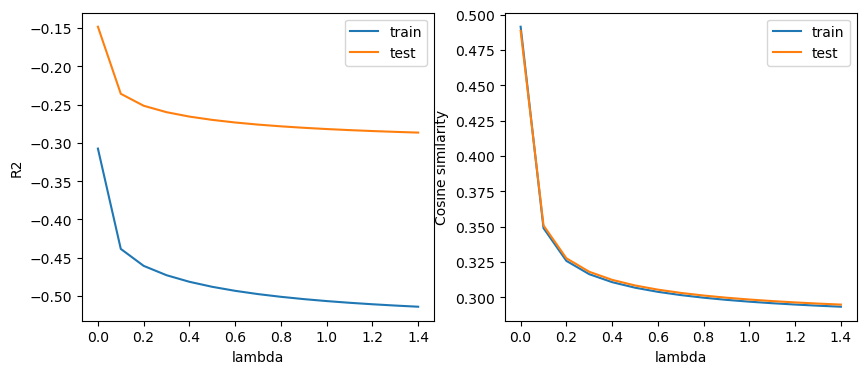

In [70]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(l_lambda_reg, l_r2_train, label='train')
ax[0].plot(l_lambda_reg, l_r2_test, label='test')
ax[0].set_xlabel("lambda")
ax[0].set_ylabel("R2")
ax[0].legend()

ax[1].plot(l_lambda_reg, l_similarity_train, label='train')
ax[1].plot(l_lambda_reg, l_similarity_test, label='test')
ax[1].set_xlabel("lambda")
ax[1].set_ylabel("Cosine similarity")
ax[1].legend()

plt.show()

In [34]:
%%time
reg = dirichlet_regression.dirichletRegressor(spatial=True)
reg.fit(X_train, Y_train, W=W_train, parametrization='alternative', gamma_0=gamma_0, Z=Z_train)

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Wall time: 1min 46s


In [35]:
r2_score(Y_train,reg.mu)

-0.36315396767676866